In [1]:
import sys
sys.path.append("..")
from blog_tools import data, embed

import scprep
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle

N_POINTS = [20, 30, 40, 50, 100]

def rescale(X):
    X -= X.min(axis=0)
    X /= X.max(axis=0)
    return X

In [2]:
from scipy.spatial.distance import pdist, squareform
from collections import defaultdict
import tasklogger
from joblib import Parallel, delayed
tasklogger.set_level(0)

In [3]:
dataset = data.uneven_circle(30, 10, 0.1, seed=42)
order = np.argsort(dataset.c)
dataset.X, dataset.c, dataset.X_true = dataset.X[order], dataset.c[order], dataset.X_true[order]
dataset.X = rescale(dataset.X)

## tSNE

In [3]:
NPY_INFINITY = np.finfo('float').max
EPSILON_DBL = 1e-8
PERPLEXITY_TOLERANCE = 1e-5

def binary_search_perplexity(sqdistances, desired_perplexity):
    n_steps = 100
    n_samples = sqdistances.shape[0]
    n_neighbors = sqdistances.shape[1]
    using_neighbors = n_neighbors < n_samples
    betas = []
    desired_entropy = np.log(desired_perplexity)
    P = np.zeros(
        (n_samples, n_neighbors), dtype=np.float64)
    for i in range(n_samples):
        beta_min = -NPY_INFINITY
        beta_max = NPY_INFINITY
        beta = 1.0
        for l in range(n_steps):
            sum_Pi = 0.0
            for j in range(n_neighbors):
                if j != i or using_neighbors:
                    P[i, j] = np.exp(-sqdistances[i, j] * beta)
                    sum_Pi += P[i, j]
            if sum_Pi == 0.0:
                sum_Pi = EPSILON_DBL
            sum_disti_Pi = 0.0
            for j in range(n_neighbors):
                P[i, j] /= sum_Pi
                sum_disti_Pi += sqdistances[i, j] * P[i, j]
            entropy = np.log(sum_Pi) + beta * sum_disti_Pi
            entropy_diff = entropy - desired_entropy
            if np.fabs(entropy_diff) <= PERPLEXITY_TOLERANCE:
                break
            if entropy_diff > 0.0:
                beta_min = beta
                if beta_max == NPY_INFINITY:
                    beta *= 2.0
                else:
                    beta = (beta + beta_max) / 2.0
            else:
                beta_max = beta
                if beta_min == -NPY_INFINITY:
                    beta /= 2.0
                else:
                    beta = (beta + beta_min) / 2.0
        betas.append(np.sqrt(1/beta))
    betas = np.array(betas)
    return betas

In [4]:
max_iter = 200

def tsne_iter(P, dataset, perplexity, n_iter):
    Y = embed.TSNE(dataset.X_true, perplexity=perplexity, n_iter=n_iter+250, seed=42, verbose=0)
    D = squareform(pdist(Y))
    Q = 1/(1+D)
    return {
        'coords' : rescale(Y),
        'distances' : D,
        'q' : Q,
        'crossentropy' : P * np.log(P / Q) * np.sign(Q - P)
    }

tsne_data = defaultdict(lambda: defaultdict(dict))

with Parallel(30) as p:
    for n_points in N_POINTS:
        print(n_points)
        dataset = data.uneven_circle(n_points, 10, 0.1, seed=42)
        order = np.argsort(dataset.c)
        dataset.X, dataset.c, dataset.X_true = dataset.X[order], dataset.c[order], dataset.X_true[order]
        for perplexity in [5, 10, 20, 50]:
            print(perplexity)

            tsne_data[n_points][perplexity] = {
                'data': dataset.X_true,
                'color': dataset.c,
                'n_points' : n_points,
                'perplexity': perplexity
            }
            tsne_data[n_points][perplexity]['distances'] = squareform(pdist(
                tsne_data[n_points][perplexity]['data']
            ))
            tsne_data[n_points][perplexity]['bandwidth'] = binary_search_perplexity(
                tsne_data[n_points][perplexity]['distances']**2, perplexity
            )
            tsne_data[n_points][perplexity]['affinity'] = np.exp(
                -1 * (tsne_data[n_points][perplexity]['distances'] / 
                      tsne_data[n_points][perplexity]['bandwidth'])**2
            )
            tsne_data[n_points][perplexity]['p'] = tsne_data[n_points][perplexity]['affinity'] / tsne_data[n_points][perplexity]['affinity'].sum(1)[:,None]

            results = p(delayed(tsne_iter)(
                    tsne_data[n_points][perplexity]['p'], dataset, perplexity, n_iter
                ) for n_iter in np.arange(max_iter))
            tsne_data[n_points][perplexity]['embedding'] = {
                n_iter : result for n_iter, result in zip(np.arange(max_iter), results)
            }

20
5
10
20
50
30
5
10
20
50
40
5
10
20
50
50
5
10
20
50
100
5
10
20
50


In [5]:
tsne_data = {k:{k2:v2 for k2,v2 in v.items()} for k, v in tsne_data.items()}

In [6]:
with open("tsne_data.pkl", 'wb') as handle:
    pickle.dump(tsne_data, handle, protocol=4)

KeyError: 'data'

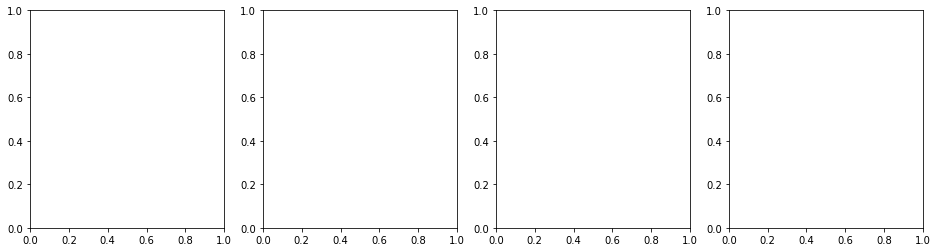

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
scprep.plot.scatter2d(tsne_data['data'], c=tsne_data['color'], ticks=False, legend=False, ax=axes[0], title='Data')
axes[1].imshow(tsne_data['distances'])
axes[1].axis('off')
axes[1].set_title("Distances", fontsize='xx-large')
scprep.plot.scatter2d(tsne_data['data'], c=tsne_data['color'], ticks=False, legend=False, ax=axes[2], title='Bandwidths')
circle(tsne_data['data'][:,0], tsne_data['data'][:,1], c=tsne_data['color'], r=tsne_data['bandwidth'],
       alpha=0.1, zorder=-2, ax=axes[2])
axes[3].imshow(tsne_data['p'])
axes[3].axis('off')
axes[3].set_title("Transition Probability", fontsize='xx-large')
fig.savefig("tsne.png")

## UMAP

In [4]:
import umap
import functools

In [5]:
umap_data = defaultdict(dict)
n_points = 20
n_neighbors = 2
seed = 42

def compute_umap(
    n_points = 20,
    n_neighbors = 2,
    seed = 42):
    
    dataset = data.uneven_circle(n_points, 10, 0.1, seed=42)
    order = np.argsort(dataset.c)
    dataset.X, dataset.c, dataset.X_true = dataset.X[order], dataset.c[order], dataset.X_true[order]

    umap_op = umap.UMAP(n_neighbors=n_neighbors, random_state=seed, n_epochs=0)
    umap_data = defaultdict(dict)
    
    umap_data['data'] = dataset.X_true
    umap_data['color'] = dataset.c

    for n_epochs in range(200):
        result = dict()
        umap_op.n_epochs = n_epochs
        result['coords'] = rescale(umap_op.fit_transform(dataset.X))
        
        if n_epochs == 0:
            umap_data['affinities'] = umap_op.graph_.toarray()
            umap_data['bandwidth'] = umap_op._sigmas
            
        result['affinities'] = 1 / (1 + umap_op._a * (squareform(pdist(result['coords'])) ** umap_op._b))
        P = umap_data['affinities'] / umap_data['affinities'].sum(1)[:,None]
        Q = result['affinities'] / result['affinities'].sum(1)[:,None]
        result['crossentropy'] = np.sum(-1 * P * np.log(Q))
        umap_data['embedding'][n_epochs] = result
    
    return umap_data

N_NEIGHBORS = [2, 3, 5, 10]
result = Parallel(30)(delayed(compute_umap)(n_points, n_neighbors) for n_points in N_POINTS for n_neighbors in N_NEIGHBORS)
i = 0
for n_points in N_POINTS:
    for n_neighbors in N_NEIGHBORS:
        umap_data[n_points][n_neighbors] = result[i]
        i += 1

umap_data = {k:{k2:v2 for k2,v2 in v.items()} for k, v in umap_data.items()}

with open("umap_data.pkl", 'wb') as handle:
    pickle.dump(umap_data, handle, protocol=4)

## MDS

In [6]:
import sklearn.manifold

mds_data = defaultdict(dict)

def compute_mds(
    n_points = 20,
    seed = 42):
    
    dataset = data.uneven_circle(n_points, 10, 0.1, seed=seed)
    order = np.argsort(dataset.c)
    dataset.X, dataset.c, dataset.X_true = dataset.X[order], dataset.c[order], dataset.X_true[order]

    random_state = np.random.RandomState(seed)
    init = random_state.rand(np.prod(dataset.X.shape)).reshape(dataset.X.shape)
    mds_op = sklearn.manifold.MDS(random_state=random_state, n_init=1, metric=True)
    mds_data = defaultdict(dict)
    
    mds_data['data'] = dataset.X_true
    mds_data['color'] = dataset.c

    mds_op.fit(dataset.X)

    for n_epochs in range(mds_op.n_iter_):
        result = dict()
        mds_op.max_iter = n_epochs

        if n_epochs == 0:
            mds_data['distances'] = mds_op.dissimilarity_matrix_
            mds_data['n_iter'] = mds_op.n_iter_
            result['coords'] = rescale(init)
        else:
            result['coords'] = rescale(mds_op.fit_transform(dataset.X, init=init))

        result['distances'] = squareform(pdist(result['coords']))

        if n_epochs == 0:
            result['stress'] = ((result['distances'].ravel() - mds_data['distances'].ravel()) ** 2).sum() / 2
        else:
            result['stress'] = mds_op.stress_

        mds_data['embedding'][n_epochs] = result

    return mds_data

In [7]:
result = Parallel(30)(delayed(compute_mds)(n_points) for n_points in N_POINTS)
i = 0
for n_points in N_POINTS:
    mds_data[n_points] = result[i]
    i += 1

mds_data = {k:{k2:v2 for k2,v2 in v.items()} for k, v in mds_data.items()}

with open("mds_data.pkl", 'wb') as handle:
    pickle.dump(mds_data, handle, protocol=4)

## ISOMAP

In [8]:
import sklearn.manifold

isomap_data = defaultdict(dict)

def compute_isomap(
    n_points = 20,
    n_neighbors = 5,
    seed = 42):
    
    dataset = data.uneven_circle(n_points, 10, 0.1, seed=seed)
    order = np.argsort(dataset.c)
    dataset.X, dataset.c, dataset.X_true = dataset.X[order], dataset.c[order], dataset.X_true[order]

    random_state = np.random.RandomState(seed)
    init = random_state.rand(np.prod(dataset.X.shape)).reshape(dataset.X.shape)
    isomap_op = sklearn.manifold.Isomap(n_neighbors=n_neighbors)
    mds_op = sklearn.manifold.MDS(random_state=random_state, metric=True, n_init=1, dissimilarity='precomputed')
    isomap_data = defaultdict(dict)
    
    isomap_data['data'] = dataset.X_true
    isomap_data['color'] = dataset.c

    isomap_op.fit(dataset.X)
    mds_op.fit(isomap_op.dist_matrix_)

    for n_epochs in range(mds_op.n_iter_):
        result = dict()
        mds_op.max_iter = n_epochs

        if n_epochs == 0:
            isomap_data['neighbors'] = sklearn.neighbors.kneighbors_graph(isomap_op.nbrs_, isomap_op.n_neighbors,
                                   metric=isomap_op.metric, p=isomap_op.p,
                                   metric_params=isomap_op.metric_params,
                                   n_jobs=isomap_op.n_jobs).toarray()
            isomap_data['weights'] = sklearn.neighbors.kneighbors_graph(isomap_op.nbrs_, isomap_op.n_neighbors,
                                   metric=isomap_op.metric, p=isomap_op.p,
                                   metric_params=isomap_op.metric_params,
                                   mode='distance', 
                                   n_jobs=isomap_op.n_jobs).toarray()
            isomap_data['distances'] = isomap_op.dist_matrix_
            isomap_data['n_iter'] = mds_op.n_iter_
            result['coords'] = rescale(init)
        else:
            result['coords'] = rescale(mds_op.fit_transform(isomap_op.dist_matrix_, init=init))

        result['distances'] = squareform(pdist(result['coords']))

        if n_epochs == 0:
            result['stress'] = ((result['distances'].ravel() - isomap_data['distances'].ravel()) ** 2).sum() / 2
        else:
            result['stress'] = mds_op.stress_

        isomap_data['embedding'][n_epochs] = result

    return isomap_data

In [9]:
result = Parallel(30)(delayed(compute_isomap)(n_points) for n_points in N_POINTS)
i = 0
N_NEIGHBORS = [2, 3, 5, 10]
for n_points in N_POINTS:
    for n_neighbors in N_NEIGHBORS:
        isomap_data[n_points][n_neighbors] = result[i]
    i += 1

isomap_data = {k:{k2:v2 for k2,v2 in v.items()} for k, v in isomap_data.items()}

with open("isomap_data.pkl", 'wb') as handle:
    pickle.dump(isomap_data, handle, protocol=4)

## PHATE

In [10]:
import sklearn.manifold
import phate
import graphtools

def compute_phate(
    n_points = 20,
    n_neighbors = 5,
    seed = 42):

    dataset = data.uneven_circle(n_points, 10, 0.1, seed=seed)
    order = np.argsort(dataset.c)
    dataset.X, dataset.c, dataset.X_true = dataset.X[order], dataset.c[order], dataset.X_true[order]

    random_state = np.random.RandomState(seed)
    phate_op = phate.PHATE()
    mds_op = sklearn.manifold.MDS(random_state=random_state, metric=True, n_init=1, dissimilarity='precomputed')
    phate_data = defaultdict(dict)
    
    phate_data['data'] = dataset.X_true
    phate_data['color'] = dataset.c

    G = graphtools.Graph(dataset.X, n_pca=100, knn=n_neighbors, thresh=0, n_landmark=None)
    phate_op.fit_transform(G)    
    
    phate_data['distances'] = squareform(pdist(
        dataset.X
    ))
    phate_data['bandwidth'] = [np.sort(d)[n_neighbors] for d in phate_data['distances']]
    phate_data['affinity'] = phate_op.graph.K
    phate_data['diffusion_op'] = phate_op.graph.P
    phate_data['powered_diffusion_op'] = np.linalg.matrix_power(phate_op.graph.P, phate_op.optimal_t)
    phate_data['potential'] = phate_op.diff_potential
    phate_data['potential_distances'] = squareform(pdist(phate_op.diff_potential))
    
    init = phate.mds.classic(phate_data['potential_distances'])
    mds_op.fit(phate_data['potential_distances'], init=init)
    phate_data['n_iter'] = mds_op.n_iter_

    for n_epochs in range(mds_op.n_iter_):
        result = dict()
        mds_op.max_iter = n_epochs

        if n_epochs == 0:
            result['coords'] = rescale(init)
        else:
            result['coords'] = rescale(mds_op.fit_transform(phate_data['potential_distances'], init=init))

        result['distances'] = squareform(pdist(result['coords']))

        if n_epochs == 0:
            result['stress'] = ((result['distances'].ravel() - phate_data['distances'].ravel()) ** 2).sum() / 2
        else:
            result['stress'] = mds_op.stress_

        phate_data['embedding'][n_epochs] = result

    return phate_data

In [11]:
result = Parallel(30)(delayed(compute_phate)(n_points) for n_points in N_POINTS)
i = 0
N_NEIGHBORS = [2, 3, 5, 10]
phate_data = defaultdict(dict)
for n_points in N_POINTS:
    for n_neighbors in N_NEIGHBORS:
        phate_data[n_points][n_neighbors] = result[i]
    i += 1

phate_data = {k:{k2:v2 for k2,v2 in v.items()} for k, v in phate_data.items()}

with open("phate_data.pkl", 'wb') as handle:
    pickle.dump(phate_data, handle, protocol=4)